In [12]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import norm, binom, multivariate_normal as mn
import pickle

In [2]:
mice = ["mpfc14", "mpfc19", "mpfc20", "mpfc23", "mpfc24", "mpfc30"]
days = ["yd1", "yd1sl", "yd2", "yd2sl", "yd6", "yd6sl"]

In [3]:
beh = []
for mi, mouse in enumerate(mice):
    behs = []
    for di, day in enumerate(days):
        if di % 2 == 0:
            behs.append(pd.read_csv("behavior/" + mouse + "/" + mouse + "_" + day + ".csv", header=None).values)
        else:
            behs.append(np.array([[]]))
    beh.append(behs)

In [4]:
with open("no_filt/h_spike_Wlim001.pkl", "rb") as f:
    h = pickle.load(f)

In [5]:
s = 5
fsize = 2 * s + 1
mu = [fsize/2, fsize/2]
sigma = [[fsize*fsize/36, 0], [0, fsize*fsize/36]]
filt = np.zeros((fsize, fsize))
for yi in range(fsize):
    for xi in range(fsize):
        filt[yi, xi] = mn.cdf([yi+1, xi+1], mean=mu, cov=sigma) + mn.cdf([yi, xi], mean=mu, cov=sigma) - mn.cdf([yi+1, xi], mean=mu, cov=sigma) - mn.cdf([yi, xi+1], mean=mu, cov=sigma)

In [6]:
n = 100
ymaze = np.zeros((n, n), dtype=bool)
for yi in range(n):
    for xi in range(n):
        if xi < 14:
            continue
        elif xi <= 56:
            if yi >= 28 and yi <= 56:
                ymaze[yi, xi] = True
        elif xi <= 75.34:
            if yi <= 31.0 / 28.0 * (xi - 56.0) + 56.0 and yi >= -31.0 / 28.0 * (xi - 84.0) - 3.0:
                ymaze[yi, xi] = True
        elif xi <= 84:
            if (yi <= 31.0 / 28.0 * (xi - 56.0) + 56.0 and yi >= 27.3 / 24.66 * (xi - 100.0) + 69.3) or \
             (yi <= -27.3 / 24.66 * (xi - 75.34) + 42.0 and yi >= -31.0 / 28.0 * (xi - 84.0) - 3.0):
                ymaze[yi, xi] = True
        else:
            if (yi <= -17.7 / 16.0 * (xi - 84.0) + 87.0 and yi >= 27.3 / 24.66 * (xi - 100.0) + 69.3) or \
             (yi <= -27.3 / 24.66 * (xi - 75.34) + 42.0 and yi >= 17.7 / 16.0 * (xi - 100.0) + 14.7):
                ymaze[yi, xi] = True

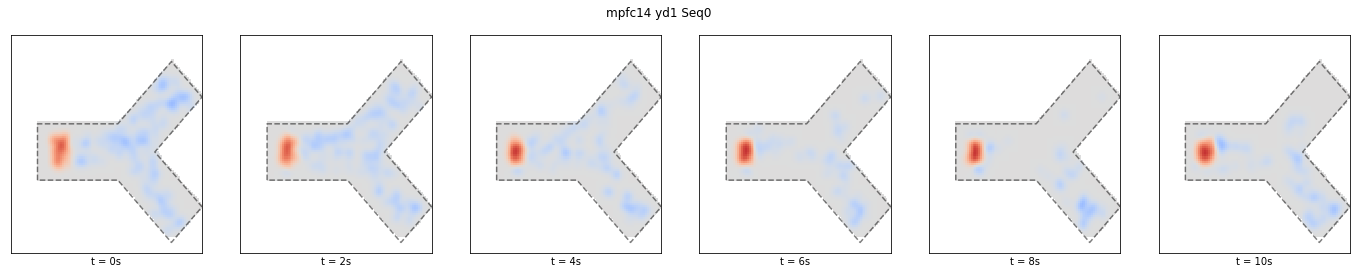

In [13]:
for mi, mouse in enumerate(mice):
    for di, day in enumerate(days):
        if di % 2 == 1:
            continue
        for wi in range(h[mi][di].shape[1]):
            fig, ax = plt.subplots(1, 6, figsize=(24, 4))
            for i in range(6):
                num = np.zeros((n, n))
                num_center = np.zeros((n, n))
    
                if i == 0:
                    htmp = h[mi][di][49:, wi].copy()
                else:
                    htmp = h[mi][di][49:-i*10, wi].copy()
                n_htmp = len(htmp)
                    
                btmp = beh[mi][di][i*10:]
                
                for hi, (xi, yi) in zip(htmp, zip(btmp[:, 3], btmp[:, 4])):
                    if hi == 1 and ~np.isnan(xi) and ~np.isnan(yi):
                        xint = int(xi * n)
                        yint = int(yi * n)
                        num[max(0, yint-s):min(n, yint+s+1), max(0, xint-s):min(n, xint+s+1)] += 1
                        num_center[yint, xint] += 1    
                
                ind = num_center > 0
                p = np.ones_like(num) * 0.5
                p[ind] = binom.cdf(num[ind], n=num[(ind) & (ymaze)].sum(), p=1/(ind & ymaze).sum())
                p_filt = np.zeros_like(p)
                for yi in range(n):
                    for xi in range(n):
                        p_filt[yi, xi] = np.sum(\
                                            p[max(0, yi-s):min(n, yi+s+1), max(0, xi-s):min(n, xi+s+1)] \
                                            * filt[max(0, s-yi):min(fsize, n+s-yi), max(0, s-xi):min(fsize, n+s-xi)]
                                        ) / filt[max(0, s-yi):min(fsize, n+s-yi), max(0, s-xi):min(fsize, n+s-xi)].sum()
                p_filt[~ymaze] = np.nan
                #p_filt[(p_filt < 0.9) & (p_filt > 0.1)] = 0.5
                #p_filt[p_filt > 0.9] = (p_filt[p_filt > 0.9] - 0.9) * 10
                #p_filt[p_filt < 0.1] = p_filt[p_filt < 0.1] * 10
                ax[i].plot([14, 14, 56, 84, 100, 75.34, 100, 84, 56, 14], [28, 56, 56, 87, 69.3, 42, 14.7, -3, 28, 28], c="k", linestyle="--", alpha=0.5)
                ax[i].pcolor(p_filt, vmin=0, vmax=1, cmap="coolwarm")
                ax[i].set_xlabel("t = " + str(i*2) + "s")
                ax[i].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
            plt.suptitle(mouse + " " + day + " Seq" + str(wi))
            filename = "no_filt/" + mouse + "_" + day + "_Seq" + str(wi) + "_loc.png"
            #plt.savefig(filename)
            plt.show()
            break
        break
    break

In [9]:
yi

nan